# Lista 5 de Otimização Natural

## 1ª Questão

### Exercício 7 do capítulo 5

Implement an EP for the Ackley function with n = 30. Make 100 runs, storing the best value foudn in each, and then calculate the mean and standard deviation of these values. Compare your results with those from exercises 5 and 6 in Chap. 4.

In [1]:
%matplotlib inline

import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    'paper',
    'white',
    'colorblind',
    font_scale=2.2,
    rc={
        'lines.linewidth': 2,
        'text.usetex': True,
        'figure.figsize': (8.0, 6.0),
        'image.interpolation': 'nearest',
        'image.cmap': 'gray'
    },
)

In [2]:
# Definições das funções usadas no exercícios.


## INICIALIZA A POPULAÇÃO
def init_indv_rand(num_alelo):
    return [b for b in np.random.uniform(low=-1, high=1, size=num_alelo)]

def eval_pop_rand(num_indv, num_alelo):
    return np.array(list(map(lambda i: init_indv_rand(num_alelo), range(num_indv))))


## INICIALIZA OS DESVIOS PADRÃO
def init_sigma_rand(num_alelo):
    return [b for b in np.random.normal(loc=0.0, scale=1.0, size=num_alelo)]

def eval_sigma_rand(num_indv, num_alelo):
    return np.array(list(map(lambda i: init_sigma_rand(num_alelo), range(num_indv))))


## FUNÇÃO A SER MINIMIZADA
def ackley_func(x):
    n = len(x)
    return -20*np.exp(-0.2*np.sqrt(1/n * np.sum(x**2))) - np.exp(1/n * np.sum(np.cos(2*np.pi*x))) + 20 + np.exp(1)


## FITNESS DA POPULAÇÃO
def eval_fitness(populacao):
    return list(map(lambda i: ackley_func(populacao[i]), range(len(populacao))))


## MUTAÇÃO
def mutation(x, sigma):
    global_uni = np.random.normal(loc=0.0, scale=1.0)
    local_uni = np.random.normal(loc=0.0, scale=1.0, size=len(sigma))    
    alpha = 0.2

    sigma_new = sigma*(1 + alpha*global_uni)
    x_new = x + sigma*local_uni   
    
    eps = 0.02
    for i, s in enumerate(sigma_new):
        if s < eps: 
            sigma_new[i] = eps       
    
    (x, sigma) = (x_new, sigma_new)
    return x, sigma

def eval_mutation(children, sigma_children, num_filhos=None):
    if num_filhos == None: num_filhos = len(children)
    
    x, sigma = [], []
    for child, sigma_child in zip(children, sigma_children):
        x_new, sigma_new = mutation(child, sigma_child)
        x.append(x_new)
        sigma.append(sigma_new)
        
    pop_chil = np.vstack((children,np.array(x)))
    pop_chil_sigma = np.vstack((sigma_children,np.array(sigma)))
    return pop_chil, pop_chil_sigma

def mutation_CEP(x, sigma):
    global_uni = np.random.normal(loc=0.0, scale=1.0)
    local_uni = np.random.normal(loc=0.0, scale=1.0, size=len(sigma))
    
    x_candidato = x + sigma*local_uni   
    
    if (ackley_func(x_candidato) < ackley_func(x)):
        x = x_candidato
        tau_prime = 1/(np.sqrt(2*len(x)))
        tau = 1/(np.sqrt(2*np.sqrt(len(x))))
        eps = 10**-2
        sigma = sigma * np.exp(tau_prime*global_uni + tau*local_uni)
        for i, s in enumerate(sigma):
            if s < eps: 
                sigma[i] = eps 
                
    return x, sigma

def eval_mutation_CEP(children, sigma_children, num_filhos=None):
    if num_filhos is None: 
        num_filhos = len(children)
        
    x, sigma = [], []
    for child, sigma_child in zip(children, sigma_children):
        x_new, sigma_new = uncorr_mut_n_stepsizes(child, sigma_child)
        x.append(x_new)
        sigma.append(sigma_new)
    return np.array(x), np.array(sigma)


def mutation_FEP(x, sigma):
    global_uni = np.random.normal(loc=0.0, scale=1.0)
    local_uni = np.random.normal(loc=0.0, scale=1.0, size=len(sigma))
    
    x_candidato = x + sigma*np.random.standard_cauchy(len(sigma))
    
    if (ackley_func(x_candidato) < ackley_func(x)):
        x = x_candidato
        tau_prime = 1/(np.sqrt(2*len(x)))
        tau = 1/(np.sqrt(2*np.sqrt(len(x))))
        eps = 10**-2
        sigma = sigma * np.exp(tau_prime*global_uni + tau*local_uni)
        for i, s in enumerate(sigma):
            if s < eps: 
                sigma[i] = eps      
                
    return x, sigma

def eval_mutation_FEP(children, sigma_children, num_filhos=None):
    if num_filhos == None: num_filhos = len(children)
        
    x, sigma = [], []
    for child, sigma_child in zip(children, sigma_children):
        x_new, sigma_new = uncorr_mut_n_stepsizes(child, sigma_child)
        x.append(x_new)
        sigma.append(sigma_new)
    return np.array(x), np.array(sigma)




def survivor_selection(everyone, everyone_sigma, num_rounds, num_survivors=None):
    if num_survivors == None: num_survivors = len(everyone)*0.5
    
    points = np.zeros(len(everyone))
    for c, competitor in enumerate(everyone):
        fitness_competitor = ackley_func(competitor)
        tds_sem_competitor = np.delete(everyone, c, axis=0)
        for i in range(num_rounds):
            other = tds_sem_competitor[np.random.choice(range(len(tds_sem_competitor[:,1])))]
            if fitness_competitor < ackley_func(other):
                points[c] += 1
    
    idx_sort = np.argsort(points)
    return everyone[idx_sort[num_survivors:]], everyone_sigma[idx_sort[num_survivors:]]

In [3]:
num_alelo = 4
num_indv = 200
num_survivors = num_indv
num_geracoes = 100
num_rounds = 10

populacao_1 = eval_pop_rand(num_indv, num_alelo)
pop_sigma_1 = eval_sigma_rand(num_indv, num_alelo)
best_x_1 = min(eval_fitness(populacao_1))
min_gen_1 = []
geracao_1 = 0

populacao_2 = eval_pop_rand(num_indv, num_alelo)
pop_sigma_2 = eval_sigma_rand(num_indv, num_alelo)
best_x_2 = min(eval_fitness(populacao_2))
min_gen_2 = []
geracao_2 = 0

populacao_3 = eval_pop_rand(num_indv, num_alelo)
pop_sigma_3 = eval_sigma_rand(num_indv, num_alelo)
best_x_3 = min(eval_fitness(populacao_3))
min_gen_3 = []
geracao_3 = 0

for i in range(num_geracoes):
    ##################### DEFAULT #####################
    total_1, total_sigma_1 = eval_mutation(populacao_1, pop_sigma_1)
    offspring_1, offspring_sigma_1 = survivor_selection(total_1, total_sigma_1, num_rounds, num_survivors)
    offspring_fitness_1 = eval_fitness(offspring_1)
    min_gen_1.append(min(offspring_fitness_1))
    
    if (min_gen_1[i] < best_x_1):
        best_x_1 = min_gen_1[i]
        geracao_1 = i
    
    populacao_1 = offspring_1
    pop_sigma_1 = offspring_sigma_1
    
    
    ##################### USANDO CEP #####################
    total_2, total_sigma_2 = eval_mutation(populacao_2, pop_sigma_2)
    offspring_2, offspring_sigma_2 = survivor_selection(total_2, total_sigma_2, num_rounds, num_survivors)
    offspring_fitness_2 = eval_fitness(offspring_2)
    min_gen_2.append(min(offspring_fitness_2))
          
    if (min_gen_2[i] < best_x_2):
        best_x_2 = min_gen_2[i]
        geracao_2 = i
        
    populacao_2 = offspring_2
    pop_sigma_2 = offspring_sigma_2
    
    
    ##################### USANDO FEP #####################   
    total_3, total_sigma_3 = eval_mutation(populacao_3, pop_sigma_3)
    offspring_3, offspring_sigma_3 = survivor_selection(total_3, total_sigma_3, num_rounds, num_survivors)
    offspring_fitness_3 = eval_fitness(offspring_3)
    min_gen_3.append(min(offspring_fitness_3))
          
    if (min_gen_3[i] < best_x_3):
        best_x_3 = min_gen_3[i]
        geracao_3 = i
        
    populacao_3 = offspring_3
    pop_sigma_3 = offspring_sigma_3
    
print(f'O mínimo {best_x_1:.5} foi encontrado na geração de número {geracao_1 + 1}.')   
print(f'O mínimo {best_x_2:.5} foi encontrado na geração de número {geracao_2 + 1}.')   
print(f'O mínimo {best_x_3:.5} foi encontrado na geração de número {geracao_3 + 1}.')   

O mínimo 0.0076297 foi encontrado na geração de número 90.
O mínimo 0.010119 foi encontrado na geração de número 39.
O mínimo 0.0072994 foi encontrado na geração de número 52.


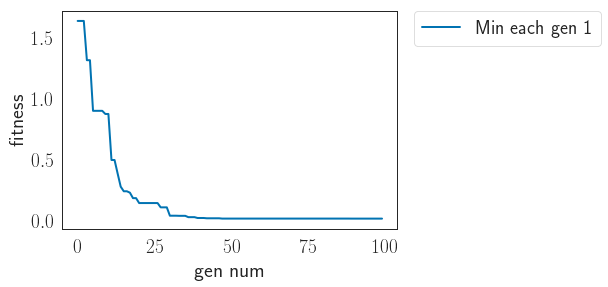

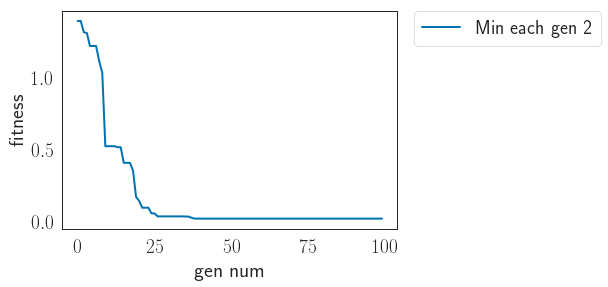

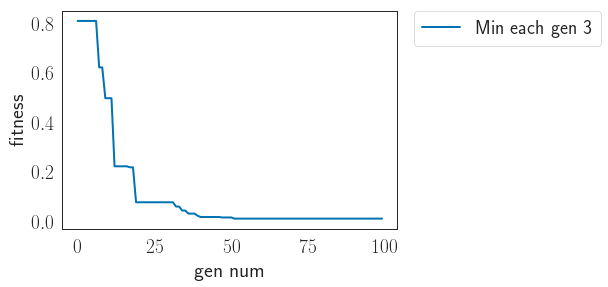

In [4]:
plt.plot(range(num_geracoes), min_gen_1, label="Min each gen 1")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('gen num')
plt.ylabel('fitness')
plt.show()

plt.plot(range(num_geracoes), min_gen_2, label="Min each gen 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('gen num')
plt.ylabel('fitness')
plt.show()

plt.plot(range(num_geracoes), min_gen_3, label="Min each gen 3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('gen num')
plt.ylabel('fitness')
plt.show()

## 2ª Questão

### Questão 1 do capítulo 14


Consider using the number of generation as a measure to establish the speed of an EA. Compare the use of this measure with using the number of fitness evaluations.
    

Resposta:

        O objetivo de usar métricas definidos pelo problema é, em geral, evitar o uso de métricas como tempo de execução em segundos, pois estas são dependentes de fatores não-reprodutíveis, como modelo do processador, quantidade de núcleos numa CPU, etc. Se o objetivo é que a métrica escolhida aja como uma substituta mais reprodutível, a quantidade de cálculos de fitness é uma boa escolha. Isso pode ser justificado mais ou menos como: muitas vezes o EA passa a maior parte do tempo calculando fitness das soluções candidatas e que enquanto o tempo necessário para calcular a fitness de um indivíduo é razoavelmente fixo, dada uma instância do problema, o tempo necessário para que o algoritmo execute uma geração depende de vários outros parâmetros, como por exemplo tamanho da população, quantidade de filhos por indivíduo, tamanho dos torneios se houverem, etc. 
        
        Desta forma, a quantidade de cálculos de fitness é uma métria mais robusta. A quantidade de gerações seria uma métirca útil em uma caso em que, por exemplo, o tamanho da popualção fosse ditado pelo problema, e o gargalo no tempo de execução do algoritmo fosse a seleção de sobreviventes, que é realizada exatamente uma vez por geração.

## 3ª Questão

### Questão 1 do capítulo 8

Give arguments why mutation strength (e.g. $p_m$ or $\sigma$) should be increased during a run. Give arguments why it should be decreased.

Resposta:
    
    Vamos considerar o uso de um GA para solucionar o problema do onemax: o cromossomo de cada indivíduo é um vetor de bits, a fitness é a quantidade de bits uns no cromossomo, e o ótimo global é o cromossomo feito somente de uns. Neste caso, a medida que a população se aproxima do ótimo global, os cromossomos dos seus indivíduos começam a ficar cada vez mais repletos de uns, o que significa que as mutações passam a ser cada vez mais certamente ruins (acabam piorando mais que melhorando). Embora isso signifique que no final do algoritmo é uma má ideia aplicar várias mutações por cromossomo, certamente é uma boa ideia aumentar a taxa de mutação para que mais indivíduos sofram mutação, uma vez que está ficando mais difícil aumentar a fitness média da população. 
    
    Por outro lado, consideremos um ES com passo auto-adapatativo. No início da execução do algoritmo, é desejável que os indivíduos deem passos largos na "fitness landscape" em questão, para que ao estimular a diversidade populacional e encontrar o ótimo global. Já no final da execução, quando a população está concentrada em torno do máximo, é desejável que os passos sejam cada vez menores, pois quanto mais perto do ponto ótimo os indivíduos estão, mais danoso é um passo largo que os leve para longe do ótimo. Em outras palavras, o passo $\sigma$ deve diminuir com o tempo para que o algoritmo possa refinra as soluções.

## 4ª Questão

Considere o problema básico de clustering em que as colunas $\mathbf{x}(n)$, $n = 1, \dots, N$ da matriz de dados $\mathbf{X}$ devem ser representadas, de forma aproximada, pelas colunas $\mathbf{y}(k)$, $n = 1, \dots, K$ do dicionário $\mathbf{Y}$ de forma que seja minimizado o erro médio quadrático:
\begin{equation}
D = \frac{1}{N} \sum^{N}_{n=1} || \mathbf{x}(n)-\mathbf{y}(k(n))||^{2}
\end{equation}
onde $k(n) = \mathrm{argmin}_{i}||\mathbf{x}(n) - \mathbf{y}(i)||$. Utilizando o pseudo-código, escreva um algoritmo genético simples, que, operando sobre uma população de dicionário $\mathbf{Y}$, leve a obtenção de uma solução $\mathbf{Y}^{*}$ localmente ótima para este problema. Defina todos os parâmetros que você julgar necessários.

### Pseudo-código

Minha ideia para esta questão é, dada a matriz de dados $\mathbf{X}$, para cada coluna dela, cada $\mathbf{x}(n)$, vou gerar uma população de $K$ $\mathbf{y}(k)$ diferentes. Com isso, vou avaliar a função a ser minimizada $k(n) = \mathrm{argmin}_{i}||\mathbf{x}(n) - \mathbf{y}(i)||$. Ao minimizar a distância a cada vetor $\mathbf{x}(n)$, a função $D$ será minimizada.

    O algoritmo vai ser:
    -- Inicialização:
      -> Gerar aleatoriamente as K populações com N vetores aleatórios.
    -- Processo evolutivo:
        -> Fazer seleção de pais usando SUS
        -> Para cada par de pais, gerar um par de filhos usando recombinação de 1 ponto.
        -> Para cada filho, fazer a mutação dos genes.
        -> Seleção de sobreviventes substituindo a população de pais pelas crianças.
   ** Fazer a evolução para cada população referente a fim de minimizar cada $\mathbf{x}(n)$.
 
De parâmetros, na hora da implementação, é preciso definir as dimensões. Para taxa de recombinação podemos usar 1/(K), uma taxa de mutação de 0.7. Outros parâmetros vão depender da magnitude de N e de K para avaliar o que é possível computacionalmente, como por exemplo se formos usar um vetor de bits aleatórios, qual é o range de bits.
        